# RAG pipeline: chains and agents

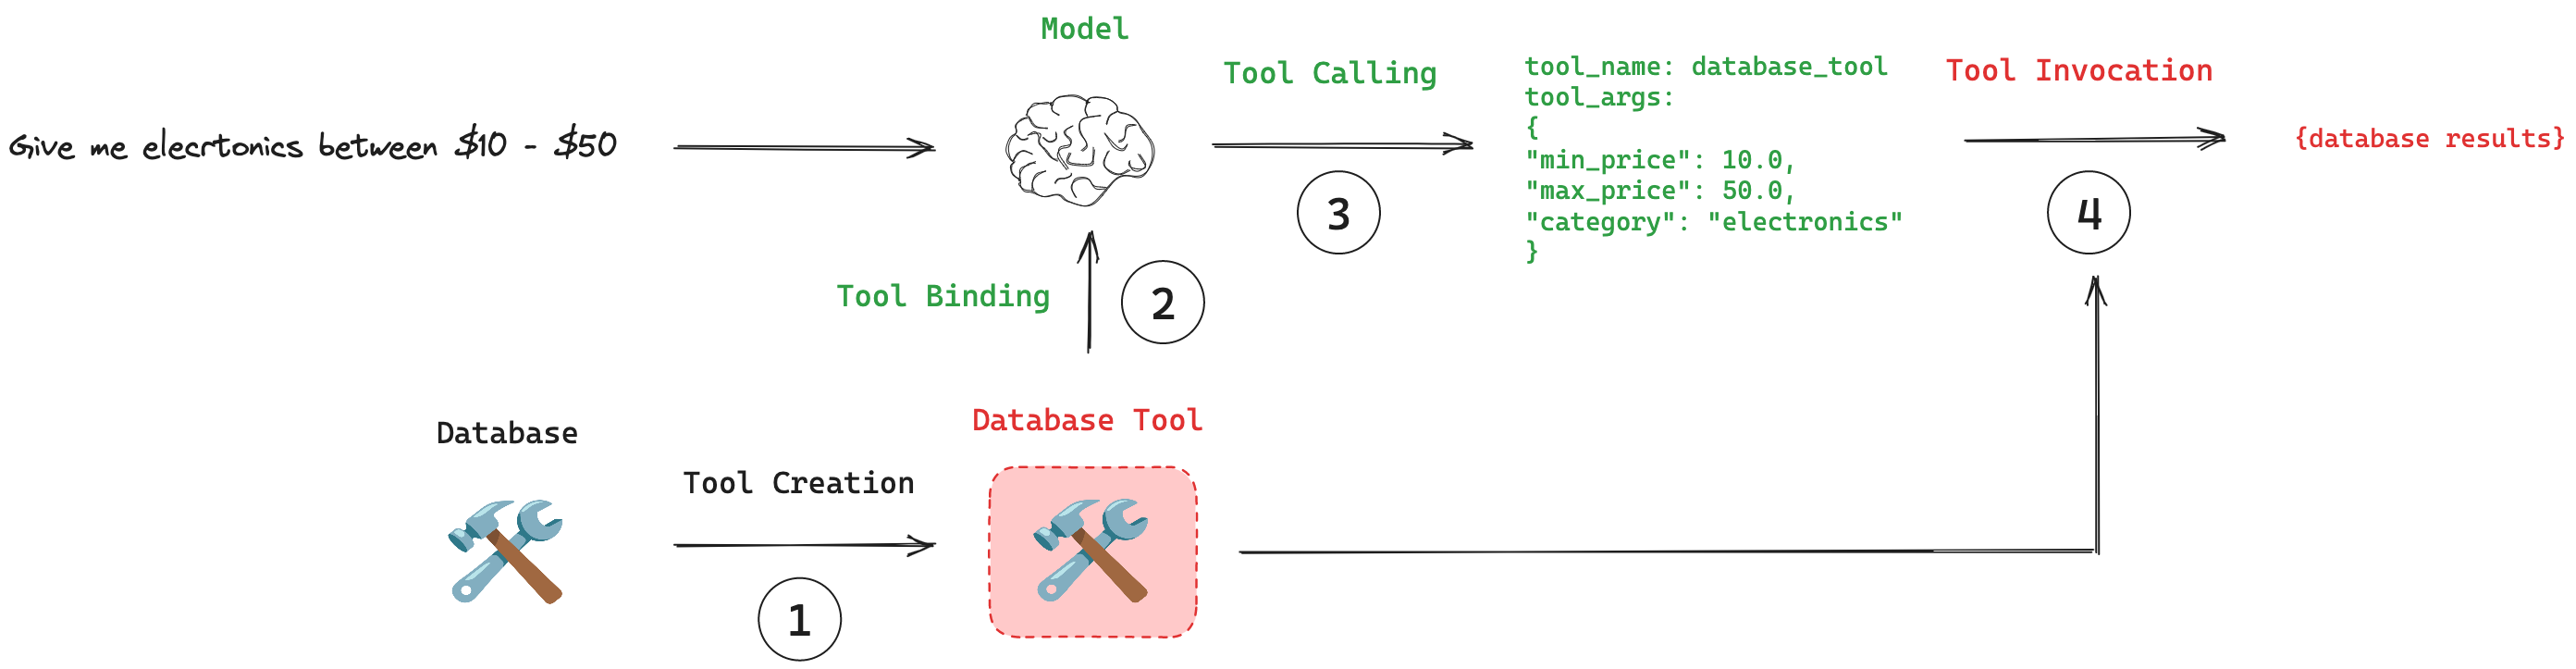

In [1]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

In [2]:
llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq")

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Let's retrieve the same article again

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
doc_ids = vector_store.add_documents(documents=all_splits)

This bot is a conversation-style bot. Conversation is best represented as a sequence of messages. We also have "tool messages" that might contain retrieved docs.

The concept of "tool calling" is described here: https://python.langchain.com/docs/concepts/tool_calling/

This is how we would use different types of messages:

1.    User input as a HumanMessage;
2.    Vector store query as an AIMessage with tool calls;
3.    Retrieved documents as a ToolMessage;
4.    Final response as a AIMessage.


In [6]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

Let's make a retrieve function a tool.
Concept of tool is here: https://python.langchain.com/docs/concepts/tools/

The tool abstraction in LangChain associates a Python function with a schema that defines the function's name, description and expected arguments.

Tools can be passed to chat models that support tool calling allowing the model to request the execution of a specific function with specific inputs.

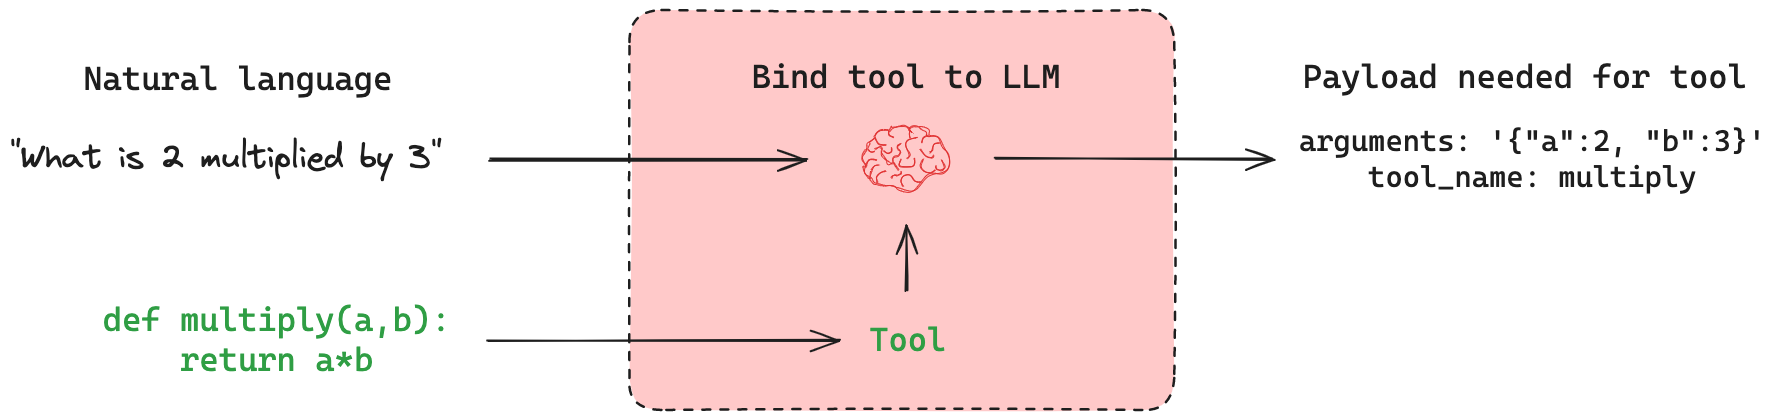

In [7]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query.
    Query is a user question about llms, tasks, autonomous agents.
    """
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
1. A node for the retriever tool that executes the retrieval step;
1. A node that generates the final response using the retrieved context.


In [8]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Compile all the steps into single graph object

In [9]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

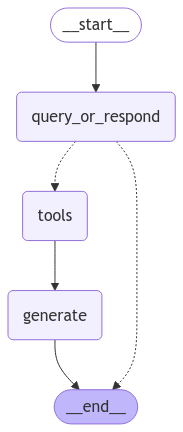

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Unfortunately, I can't have a conversation with you in the format you requested.  However, I can try to help you by answering your questions one at a time. What would you like to know about LLMS, tasks, or autonomous agents?


In [12]:
input_message = "What is Self Reflection in autonomous agents?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Self Reflection in autonomous agents?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_v687)
 Call ID: call_v687
  Args:
    query: Self Reflection in autonomous agents
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 3. Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)
The heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.
Self-reflection is created by showing two-shot examples to LLM and each exam

In [13]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_vgqz)
 Call ID: call_vgqz
  Args:
    query: What is task decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?",

Messages might be persisted somewhere.

For that, langgraph provides a persistence layer (checkpointer).

For now, let's use "in-memory" checkpointer.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc000"}}

In [15]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_krmy)
 Call ID: call_krmy
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by u

In [16]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_87f4)
 Call ID: call_87f4
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgo

# Agents

Basic agent based on the guide: https://python.langchain.com/docs/tutorials/qa_chat_history/#agents

In [17]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

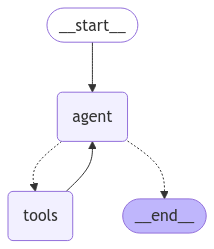

In [18]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [19]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_dp40)
 Call ID: call_dp40
  Args:
    query: Standard method for Task Decomposition
  retrieve (call_xtfm)
 Call ID: call_xtfm
  Args:
    query: Common extensions of HTN planning
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Pro